In [109]:
from scipy.io import wavfile as WF

from IPython.display import Audio
import pandas as pd
import numpy as np
from numpy.fft import fft
from scipy.signal import * 
import matplotlib.pyplot as plt

from tqdm import tqdm

In [19]:
def thirdoct(rate, k, n_bands, mn):
    freqs = np.linspace(0, rate, k + 1)
    freqs = freqs[0:int(k/2 + 1)]
    q = np.arange(n_bands)
    cf = np.power(2, q/3.) * mn
    fl = np.sqrt((np.power(2., q/3.) * mn) * (np.power(2., (q - 1.)/3.) * mn))
    fr = np.sqrt((np.power(2., q/3.) * mn) * (np.power(2., (q + 1.)/3.) * mn))
    A = np.zeros((n_bands, freqs.shape[0]))
    for i in range(cf.shape[0]):
        tmp = np.square(freqs-fl[i])
        a, b = np.min(tmp), np.argmin(tmp)
        fl[i] = freqs[b]
        flii = b
        
        tmp = np.square(freqs-fr[i])
        a, b = np.min(tmp), np.argmin(tmp)
        fr[i] = freqs[b]
        frii = b
        A[i, flii:(frii)] = 1
    rnk = np.sum(A, axis=1)
    nb_ = np.where(np.logical_and(rnk[1:] >= rnk[:-1], rnk[1:] != 0))[0]
    nb = nb_[-1] + 2 #because matlab
    A = A[:nb, :]
    cf = cf[:nb]
    return A, cf

def stdft(x, N, K, N_fft): 
    frames = np.arange(0, x.shape[0]-N, K)
    x_stdft = np.zeros((frames.shape[0], N_fft), dtype=np.complex)
    w = hanning(N)
    x = x.T
    for i in range(frames.shape[0]):
        if (x[frames[i: i + N]].shape != w.shape):
            tmp = np.zeros_like(w)
            q = x[frames[i: i + N]]
            tmp[:q.shape[0]] = q
            x_stdft[i, :] = fft(tmp * w, n=N_fft)
        else:
            x_stdft[i, :] = fft(x[frames[i: i + N]] * w, n=N_fft)
    return x_stdft

def taa_corr(x, y):
    def normalize(x):
        xn = x - np.mean(x)
        return xn / np.sqrt(np.square(xn).sum())
    
    return np.dot(normalize(x), normalize(y)).sum()

def intermediate_metric(x, y, n_frame=256, k=512, J=15, N=30, n_bands=15, cf=150, rate=16000):
    H,_ = thirdoct(rate, k, n_bands, cf) #1/3 octave band matrix
    
    x_hat = stdft(x, n_frame, int(n_frame / 2), k)
    y_hat = stdft(y, n_frame, int(n_frame / 2), k)

    x_hat = x_hat[:, :int(k/2) + 1].T
    y_hat = y_hat[:, :int(k/2) + 1].T

    X = np.zeros((J, x_hat.shape[1]))
    Y = np.zeros((J, y_hat.shape[1]))
    for i in range(x_hat.shape[1]):
        X[:, i] = np.sqrt(np.dot(H, np.square(np.abs(x_hat[:, i]))))
        Y[:, i] = np.sqrt(np.dot(H, np.square(np.abs(y_hat[:, i]))))

    # allocating memory for intermediate measures
    d_interm = np.zeros((J, X.shape[1] - N))
    c=np.power(10., 0.75) #clipping constant

    for m in range(N, X.shape[1]):
        X_seg = X[:, (m - N):m]
        Y_seg = Y[:, (m - N):m] 
        alpha = np.sqrt(np.sum(np.square(X_seg), axis=1) / np.sum(np.square(Y_seg), axis=1))
        aY_seg = Y_seg * np.matlib.repmat(alpha, 1, N).reshape(Y_seg.shape)
        for j in range(J):
            Y_prime = np.minimum(aY_seg[j, :], X_seg[j, :] + X_seg[j, :] * c)
            d_interm[j, m-N] = taa_corr(X_seg[j, :].T, Y_prime)

    return d_interm

def stoi(x, y):
    return np.mean(intermediate_metric(x, y))

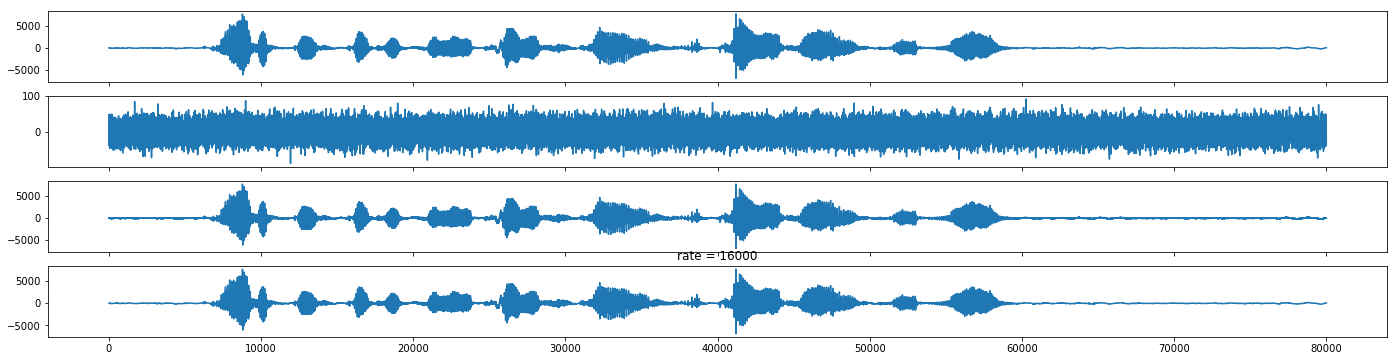

In [167]:
rate, data = WF.read('sound.wav')
plt.plot(data)
plt.title('rate = {}'.format(rate))
plt.show()

In [168]:
def gen_noise(magn=10, size=80000):
    return np.random.normal(scale=magn, size=size).astype(np.int16)

In [169]:
n_frame = 256 # window
k = 512 # fft size
J = 15
N = 30
n_bands = 15
cf = 150 # center frequency of first 1/3 octave band in Hz
x = data
noise = gen_noise(200)
y = data + noise

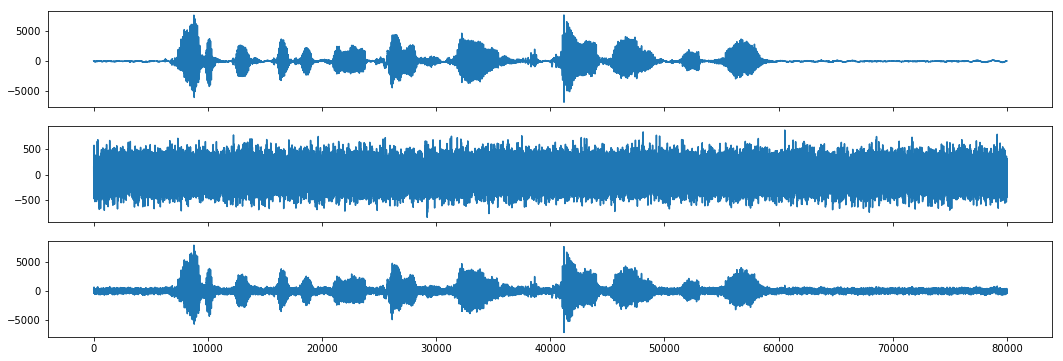

In [175]:
fig, ax = plt.subplots(3, 1, figsize=(18, 6), sharex=True)
ax[0].plot(x)
ax[1].plot(noise)
ax[2].plot(y)
plt.show()

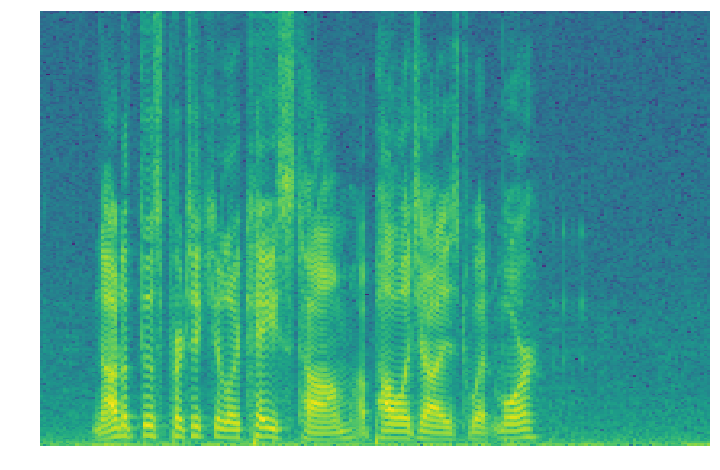

In [182]:
plt.figure(figsize=(12, 8))
_, _, _, im = plt.specgram(data, Fs=1e4, NFFT=512)
plt.axis('off')
plt.show()

In [149]:
d_interm = intermediate_metric(x, y)
d = stoi(x, y)

In [150]:
noise_magn = np.array([0, 1, 2, 5, 10, 20, 30, 40, 50, 80, 100, 120, 150, 180, 200, 250, 300, 350, 400])
d = np.array([stoi(x, x + gen_noise(m)) for m in noise_magn])

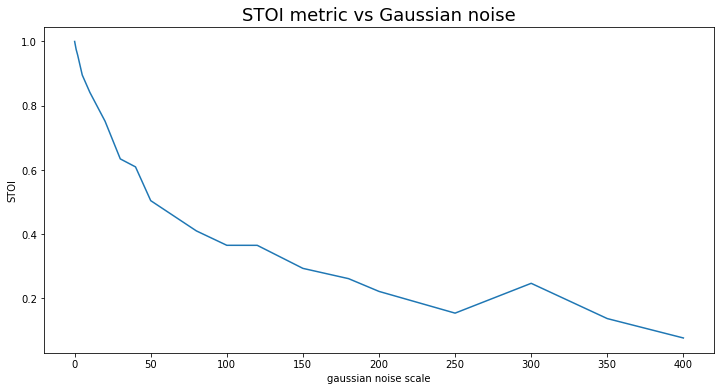

In [151]:
plt.figure(figsize=(12, 6))
plt.plot(noise_magn, d)
plt.xlabel('gaussian noise scale')
plt.ylabel('STOI')
plt.title('STOI metric vs Gaussian noise', fontsize=18)
plt.show()

In [152]:
frames = np.arange(0, data.shape[0]-256, 128)
windows = np.array([data[frames[i]: frames[i+2]] for i in range(frames.shape[0] - 2)])
windows.shape

(621, 256)

In [183]:
x = data
noise = gen_noise(20)
y = data + noise
d_interm = intermediate_metric(y, x)

In [184]:
d_ = d_interm.mean(axis=0)

(593,)


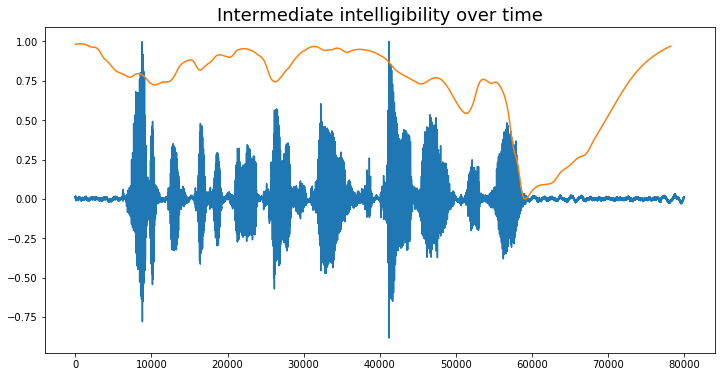

In [185]:
print(d_.shape)
t=580
plt.figure(figsize=(12, 6))
plt.plot(y / np.max(y))
plt.plot(np.linspace(0, x.shape[0], d_.shape[0])[:t], norm(d_ + np.min(d_))[:t])
plt.title('Intermediate intelligibility over time', fontsize=18)
plt.show()